In [1]:
import requests
import pandas as pd
import numpy as np

# Season Numbers

In [2]:
url = 'https://fantasy.premierleague.com/api/bootstrap-static/'
r = requests.get(url)
json = r.json()
json.keys()

dict_keys(['events', 'game_settings', 'phases', 'teams', 'total_players', 'elements', 'element_stats', 'element_types'])

In [3]:
#move data from jsons files to pandas Dataframes. 
elements_df = pd.DataFrame(json['elements']) #Player stats
elements_types_df = pd.DataFrame(json['element_types']) #player descs
teams_df = pd.DataFrame(json['teams']) #team descs

In [4]:
#check what variables are available
elements_df.columns

Index(['chance_of_playing_next_round', 'chance_of_playing_this_round', 'code',
       'cost_change_event', 'cost_change_event_fall', 'cost_change_start',
       'cost_change_start_fall', 'dreamteam_count', 'element_type', 'ep_next',
       'ep_this', 'event_points', 'first_name', 'form', 'id', 'in_dreamteam',
       'news', 'news_added', 'now_cost', 'photo', 'points_per_game',
       'second_name', 'selected_by_percent', 'special', 'squad_number',
       'status', 'team', 'team_code', 'total_points', 'transfers_in',
       'transfers_in_event', 'transfers_out', 'transfers_out_event',
       'value_form', 'value_season', 'web_name', 'minutes', 'goals_scored',
       'assists', 'clean_sheets', 'goals_conceded', 'own_goals',
       'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards',
       'saves', 'bonus', 'bps', 'influence', 'creativity', 'threat',
       'ict_index', 'influence_rank', 'influence_rank_type', 'creativity_rank',
       'creativity_rank_type', 'threat_rank'

In [5]:
# we select the following columns to our "slim" df, more can be added
slim_elements_df = elements_df[['web_name','team','element_type','selected_by_percent','now_cost','minutes','goals_scored','assists','bps','clean_sheets','transfers_in','transfers_out','transfers_in_event','transfers_out_event','value_season','value_form','form','total_points','direct_freekicks_order','penalties_order']]
#change some category numbers to more descriptive vars, change back before forecasting
slim_elements_df['position'] = slim_elements_df.element_type.map(elements_types_df.set_index('id').singular_name_short)
slim_elements_df['team'] = slim_elements_df.team.map(teams_df.set_index('id').short_name)
#some numbers are not floats but objects
slim_elements_df['ptPerMil'] = slim_elements_df.value_season.astype(float)
slim_elements_df['formPerMil'] = slim_elements_df.value_form.astype(float)
slim_elements_df['form'] = slim_elements_df.form.astype(float)
slim_elements_df['ptPerMil'] = slim_elements_df.value_season.astype(float)
slim_elements_df = slim_elements_df.drop(["element_type","value_season","value_form"],axis=1) #more descriptive names used
slim_elements_df.head()

,web_name,team,selected_by_percent,now_cost,minutes,goals_scored,assists,bps,clean_sheets,transfers_in,transfers_out,transfers_in_event,transfers_out_event,form,total_points,direct_freekicks_order,penalties_order,position,ptPerMil,formPerMil
0,Özil,ARS,0.5,67,0,0,0,0,0,3441,53842,0,68,0.0,0,NaN,NaN,MID,0.0,0.0
1,Sokratis,ARS,0.1,48,0,0,0,0,0,10266,18976,0,8,0.0,0,NaN,NaN,DEF,0.0,0.0
2,David Luiz,ARS,0.8,54,839,0,0,143,3,47289,94595,2736,497,3.8,28,4.0,NaN,DEF,5.2,0.7
3,Aubameyang,ARS,6.5,113,1514,5,1,202,7,561597,3256923,570,8296,4.2,71,NaN,1.0,MID,6.3,0.4
4,Cédric,ARS,0.2,46,275,0,1,71,2,11924,37058,2937,356,3.8,20,NaN,NaN,DEF,4.3,0.8


In [6]:
#net transfers should be good enough, if needed at all
slim_elements_df['net_transfers'] = slim_elements_df['transfers_in'] - slim_elements_df['transfers_out']
slim_elements_df['net_transfers_event'] = slim_elements_df['transfers_in_event'] - slim_elements_df['transfers_out_event']
slim_elements_df = slim_elements_df.drop(["transfers_in","transfers_out","transfers_in_event","transfers_out_event"],axis=1)

slim_elements_df.head()

,web_name,team,selected_by_percent,now_cost,minutes,goals_scored,assists,bps,clean_sheets,form,total_points,direct_freekicks_order,penalties_order,position,ptPerMil,formPerMil,net_transfers,net_transfers_event
0,Özil,ARS,0.5,67,0,0,0,0,0,0.0,0,NaN,NaN,MID,0.0,0.0,-50401,-68
1,Sokratis,ARS,0.1,48,0,0,0,0,0,0.0,0,NaN,NaN,DEF,0.0,0.0,-8710,-8
2,David Luiz,ARS,0.8,54,839,0,0,143,3,3.8,28,4.0,NaN,DEF,5.2,0.7,-47306,2239
3,Aubameyang,ARS,6.5,113,1514,5,1,202,7,4.2,71,NaN,1.0,MID,6.3,0.4,-2695326,-7726
4,Cédric,ARS,0.2,46,275,0,1,71,2,3.8,20,NaN,NaN,DEF,4.3,0.8,-25134,2581


In [7]:
#lets drop all players that have not yet played 2 games (=180 minutes)
slim_elements_df = slim_elements_df.loc[slim_elements_df.minutes > 180]

In [8]:
#top 10 points per million 
slim_elements_df.sort_values('ptPerMil',ascending=False).head(10)

,web_name,team,selected_by_percent,now_cost,minutes,goals_scored,assists,bps,clean_sheets,form,total_points,direct_freekicks_order,penalties_order,position,ptPerMil,formPerMil,net_transfers,net_transfers_event
35,Martínez,AVL,33.3,51,1710,0,0,444,10,5.0,103,NaN,NaN,GKP,20.2,1.0,1903710,41786
601,Soucek,WHU,18.5,53,1890,7,1,333,7,5.0,97,NaN,NaN,MID,18.3,0.9,1063142,18294
120,Pope,BUR,10.9,54,1710,0,0,418,7,4.6,98,NaN,NaN,GKP,18.1,0.9,-335597,-2642
296,Bamford,LEE,47.3,66,1695,11,7,388,6,6.0,119,NaN,1.0,FWD,18.0,0.9,2942008,35180
50,Targett,AVL,7.3,47,1694,0,3,385,11,7.0,84,6.0,NaN,DEF,17.9,1.5,475906,61417
7,Leno,ARS,9.3,50,1890,0,0,407,8,5.8,89,NaN,NaN,GKP,17.8,1.2,52691,12741
588,Cresswell,WHU,21.1,55,1890,0,8,453,7,4.8,96,1.0,NaN,DEF,17.5,0.9,1476943,85668
294,Dallas,LEE,13.4,48,1790,4,2,389,6,3.7,82,NaN,NaN,DEF,17.1,0.8,686745,30748
496,Bednarek,SOU,12.4,49,1710,1,1,397,8,2.8,83,NaN,NaN,DEF,16.9,0.6,723495,-17501
484,McCarthy,SOU,18.6,46,1710,0,0,355,7,1.2,76,NaN,NaN,GKP,16.5,0.3,-152465,-15422


In [9]:
#top 10 form per million
slim_elements_df.sort_values('formPerMil',ascending=False).head(10)

,web_name,team,selected_by_percent,now_cost,minutes,goals_scored,assists,bps,clean_sheets,form,total_points,direct_freekicks_order,penalties_order,position,ptPerMil,formPerMil,net_transfers,net_transfers_event
50,Targett,AVL,7.3,47,1694,0,3,385,11,7.0,84,6.0,NaN,DEF,17.9,1.5,475906,61417
570,Pereira,WBA,1.8,56,1272,5,4,278,2,8.2,73,1.0,NaN,MID,13.0,1.5,-77398,50486
14,Holding,ARS,5.6,45,1575,0,1,343,8,6.4,68,NaN,NaN,DEF,15.1,1.4,310207,44454
606,Dawson,WHU,0.5,45,540,2,0,126,3,6.0,36,NaN,NaN,DEF,8.0,1.3,34790,6944
355,Gündogan,MCI,18.7,58,1125,7,0,320,9,7.8,83,4.0,2.0,MID,14.3,1.3,1420918,41643
357,Stones,MCI,20.4,52,990,2,0,297,9,6.8,77,NaN,NaN,DEF,14.8,1.3,1540803,-21238
74,Dunk,BHA,2.6,48,1620,2,0,310,5,5.8,57,1.0,NaN,DEF,11.9,1.2,-383891,1237
315,Raphinha,LEE,1.4,54,1076,3,4,215,4,6.7,60,4.0,NaN,MID,11.1,1.2,97682,-3316
7,Leno,ARS,9.3,50,1890,0,0,407,8,5.8,89,NaN,NaN,GKP,17.8,1.2,52691,12741
22,Saka,ARS,10.8,54,1503,5,3,285,6,6.6,81,6.0,NaN,MID,15.0,1.2,308566,-85698


In [11]:
#what position offers the best return per mill, what position is most under/overrated
pivot=slim_elements_df.pivot_table(index='position',values='ptPerMil',aggfunc=np.mean).reset_index()
pivot.sort_values('ptPerMil',ascending=False)

,position,ptPerMil
2,GKP,12.947826
0,DEF,7.614865
1,FWD,7.527660
3,MID,7.002874


In [29]:
# what position is most in form per million
pivot = slim_elements_df.pivot_table(index='position',values='formPerMil',aggfunc=np.mean).reset_index()
pivot.sort_values('formPerMil',ascending=False)

,position,formPerMil
2,GKP,0.626087
0,DEF,0.394595
3,MID,0.352874
1,FWD,0.306383


In [13]:
#what team is the best value?
team_pivot = slim_elements_df.pivot_table(index='team',values='ptPerMil',aggfunc=np.mean).reset_index()
team_pivot.sort_values('ptPerMil',ascending=False)

,team,ptPerMil
1,AVL,11.006250
15,SOU,10.162500
8,LEE,9.450000
18,WHU,9.231579
11,MCI,8.440000
19,WOL,8.161111
4,CHE,7.895238
9,LEI,7.840000
2,BHA,7.725000
0,ARS,7.508696


In [30]:
#what team is most in form?
team_pivot = slim_elements_df.pivot_table(index='team',values='form',aggfunc=np.mean).reset_index()
team_pivot.sort_values('form',ascending=False)

,team,form
11,MCI,3.595000
1,AVL,3.068750
0,ARS,2.739130
9,LEI,2.440000
18,WHU,2.405263
2,BHA,2.350000
12,MUN,2.330000
4,CHE,2.171429
8,LEE,2.122222
5,CRY,1.923810


In [31]:
fwd_df = slim_elements_df.loc[slim_elements_df.position == 'FWD']
mid_df = slim_elements_df.loc[slim_elements_df.position == 'MID']
def_df = slim_elements_df.loc[slim_elements_df.position == 'DEF']
goal_df = slim_elements_df.loc[slim_elements_df.position == 'GKP']

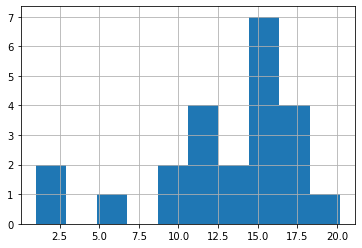

In [32]:
goal_df.ptPerMil.hist()

In [33]:
goal_df.sort_values('ptPerMil',ascending=False).head(10)

,web_name,team,selected_by_percent,now_cost,minutes,goals_scored,assists,bps,clean_sheets,form,total_points,direct_freekicks_order,penalties_order,position,ptPerMil,formPerMil,net_transfers,net_transfers_event
35,Martínez,AVL,33.3,51,1710,0,0,444,10,5.0,103,NaN,NaN,GKP,20.2,1.0,1903710,41786
120,Pope,BUR,10.9,54,1710,0,0,418,7,4.6,98,NaN,NaN,GKP,18.1,0.9,-335597,-2642
7,Leno,ARS,9.3,50,1890,0,0,407,8,5.8,89,NaN,NaN,GKP,17.8,1.2,52691,12741
484,McCarthy,SOU,18.6,46,1710,0,0,355,7,1.2,76,NaN,NaN,GKP,16.5,0.3,-152465,-15422
307,Meslier,LEE,5.7,47,1710,0,0,420,6,2.3,77,NaN,NaN,GKP,16.4,0.5,302091,-3607
584,Fabianski,WHU,3.8,51,1800,0,0,370,6,2.5,81,NaN,NaN,GKP,15.9,0.5,110216,-3401
250,Areola,FUL,3.2,45,1710,0,0,354,4,3.8,69,NaN,NaN,GKP,15.3,0.8,124368,-3069
259,Schmeichel,LEI,10.2,55,1890,0,0,379,7,4.6,84,NaN,NaN,GKP,15.3,0.8,-263417,133
166,Guaita,CRY,3.2,48,1890,0,0,366,4,5.0,72,NaN,NaN,GKP,15.0,1.0,11494,3592
424,Darlow,NEW,2.0,50,1890,0,0,397,4,2.3,74,NaN,NaN,GKP,14.8,0.5,87294,-655


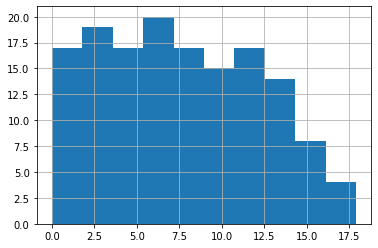

In [34]:
def_df.ptPerMil.hist()

In [35]:
def_df.sort_values('ptPerMil',ascending=False).head(10)

,web_name,team,selected_by_percent,now_cost,minutes,goals_scored,assists,bps,clean_sheets,form,total_points,direct_freekicks_order,penalties_order,position,ptPerMil,formPerMil,net_transfers,net_transfers_event
50,Targett,AVL,7.3,47,1694,0,3,385,11,7.0,84,6.0,NaN,DEF,17.9,1.5,475906,61417
588,Cresswell,WHU,21.1,55,1890,0,8,453,7,4.8,96,1.0,NaN,DEF,17.5,0.9,1476943,85668
294,Dallas,LEE,13.4,48,1790,4,2,389,6,3.7,82,NaN,NaN,DEF,17.1,0.8,686745,30748
496,Bednarek,SOU,12.4,49,1710,1,1,397,8,2.8,83,NaN,NaN,DEF,16.9,0.6,723495,-17501
377,Dias,MCI,18.3,60,1599,0,1,401,12,6.8,91,NaN,NaN,DEF,15.2,1.1,1375097,144411
280,Justin,LEI,26.8,51,1890,1,2,381,7,3.4,77,NaN,NaN,DEF,15.1,0.7,1123357,17694
14,Holding,ARS,5.6,45,1575,0,1,343,8,6.4,68,NaN,NaN,DEF,15.1,1.4,310207,44454
585,Ogbonna,WHU,2.9,50,1862,2,0,341,7,2.2,75,NaN,NaN,DEF,15.0,0.4,171216,-4636
54,Konsa,AVL,5.2,46,1485,2,0,295,7,4.0,69,NaN,NaN,DEF,15.0,0.9,280921,-554
495,Walker-Peters,SOU,8.0,47,1620,0,2,354,8,1.8,70,NaN,NaN,DEF,14.9,0.4,-226419,-91487


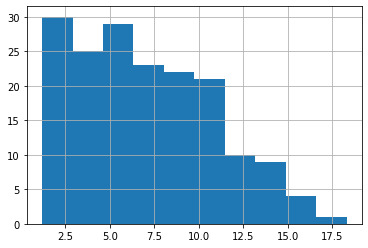

In [36]:
mid_df.ptPerMil.hist()

In [37]:
mid_df.sort_values('ptPerMil',ascending=False).head(10)

,web_name,team,selected_by_percent,now_cost,minutes,goals_scored,assists,bps,clean_sheets,form,total_points,direct_freekicks_order,penalties_order,position,ptPerMil,formPerMil,net_transfers,net_transfers_event
601,Soucek,WHU,18.5,53,1890,7,1,333,7,5.0,97,NaN,NaN,MID,18.3,0.9,1063142,18294
297,Harrison,LEE,2.1,54,1579,5,4,286,6,6.0,85,3.0,NaN,MID,15.7,1.1,58513,7847
45,Grealish,AVL,38.9,77,1707,6,11,457,10,5.5,119,4.0,2.0,MID,15.5,0.7,2034054,90060
629,Neto,WOL,8.1,58,1711,4,5,351,6,2.6,88,4.0,NaN,MID,15.2,0.4,532650,-55147
22,Saka,ARS,10.8,54,1503,5,3,285,6,6.6,81,6.0,NaN,MID,15.0,1.2,308566,-85698
522,Son,TOT,58.5,98,1706,12,6,458,8,2.8,143,6.0,2.0,MID,14.6,0.3,2140120,-99858
491,Ward-Prowse,SOU,9.0,61,1800,4,5,412,8,3.5,87,1.0,2.0,MID,14.3,0.6,327661,-34050
355,Gündogan,MCI,18.7,58,1125,7,0,320,9,7.8,83,4.0,2.0,MID,14.3,1.3,1420918,41643
179,Zaha,CRY,15.1,72,1610,9,3,250,4,3.0,101,NaN,3.0,MID,14.0,0.4,237738,17927
598,Bowen,WHU,2.6,62,1620,5,3,265,6,4.2,85,NaN,NaN,MID,13.7,0.7,46123,-6271


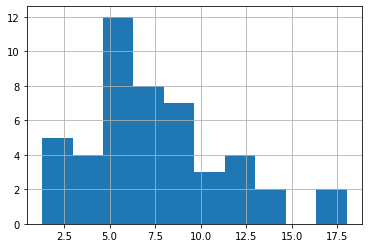

In [38]:
fwd_df.ptPerMil.hist()

In [39]:
fwd_df.sort_values('ptPerMil',ascending=False).head(10)

,web_name,team,selected_by_percent,now_cost,minutes,goals_scored,assists,bps,clean_sheets,form,total_points,direct_freekicks_order,penalties_order,position,ptPerMil,formPerMil,net_transfers,net_transfers_event
296,Bamford,LEE,47.3,66,1695,11,7,388,6,6.0,119,NaN,1.0,FWD,18.0,0.9,2942008,35180
447,Wilson,NEW,21.7,67,1687,10,5,345,5,4.3,110,NaN,1.0,FWD,16.4,0.6,909433,296582
63,Watkins,AVL,17.4,63,1710,8,4,273,10,4.0,85,NaN,3.0,FWD,13.5,0.6,1215721,68890
209,Calvert-Lewin,EVE,38.7,76,1583,11,4,346,5,1.3,99,NaN,NaN,FWD,13.0,0.2,1816284,18619
520,Kane,TOT,24.5,111,1654,12,11,512,6,4.5,143,1.0,1.0,FWD,12.9,0.4,414899,-525640
497,Adams,SOU,5.0,59,1532,4,5,241,6,1.2,75,NaN,NaN,FWD,12.7,0.2,36812,-17857
80,Maupay,BHA,3.1,61,1386,7,1,233,5,4.0,72,NaN,2.0,FWD,11.8,0.7,48578,-3917
266,Vardy,LEI,13.9,100,1476,11,8,412,6,1.8,116,NaN,1.0,FWD,11.6,0.2,-574663,-58504
454,McGoldrick,SHU,2.2,52,1208,5,1,195,5,2.8,59,NaN,NaN,FWD,11.3,0.5,82186,5107
235,Decordova-Reid,FUL,1.0,53,1259,5,1,237,5,2.4,56,NaN,NaN,FWD,10.6,0.5,59528,3686


# Data by GW

In [40]:
pd.options.display.max_columns = None

In [41]:
url = f'https://fantasy.premierleague.com/api/element-summary/1/'
r = requests.get(url)
json = r.json()
json.keys()

dict_keys(['fixtures', 'history', 'history_past'])

In [42]:
json_fixtures_df = pd.DataFrame(json['fixtures'])
json_history_df = pd.DataFrame(json['history'])
json_history_past_df = pd.DataFrame(json['history_past'])

In [43]:
json_history_past_df.head()

,season_name,element_code,start_cost,end_cost,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index
0,2013/14,37605,100,96,137,2141,5,10,13,23,0,0,0,0,0,0,18,162,0.0,0.0,0.0,0.0
1,2014/15,37605,90,90,103,1857,4,6,9,16,0,0,0,0,0,0,13,511,0.0,0.0,0.0,0.0
2,2015/16,37605,85,92,200,3036,6,19,17,31,0,0,0,4,0,0,30,861,0.0,0.0,0.0,0.0
3,2016/17,37605,95,95,167,2841,8,11,12,30,0,0,0,2,0,0,19,729,834.4,1649.3,734.0,322.0
4,2017/18,37605,95,93,112,2161,4,9,8,36,0,0,0,4,0,0,11,506,640.6,1287.5,555.0,248.6


In [44]:
for x in elements_df.index :
    element_id = elements_df.id[x]
    url = f'https://fantasy.premierleague.com/api/element-summary/{element_id}/'
    r = requests.get(url)
    json = r.json()
    json_history_df = pd.DataFrame(json['history'])
    json_history_past_df = pd.DataFrame(json['history_past'])
    
    if x == 0 :
        all_history_df = json_history_df
        all_history_past_df = json_history_past_df
    else : 
        all_history_df = all_history_df.append(json_history_df)
        all_history_past_df = all_history_past_df.append(json_history_past_df)
all_history_df.head()


,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,round,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,value,transfers_balance,selected,transfers_in,transfers_out
0,1,2,8,0,False,2020-09-12T11:30:00Z,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,70,0,76656,0,0
1,1,9,19,0,True,2020-09-19T19:00:00Z,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,69,-16828,68335,995,17823
2,1,23,11,0,False,2020-09-28T19:00:00Z,3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,69,-11451,59793,675,12126
3,1,29,15,0,True,2020-10-04T13:00:00Z,2,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,68,-5324,56403,647,5971
4,1,44,12,0,False,2020-10-17T16:30:00Z,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,68,-4224,53689,616,4840


In [45]:
all_history_df['element'] = all_history_df.element.map(elements_df.set_index('id').web_name)
all_history_df['opponent_team'] = all_history_df.opponent_team.map(teams_df.set_index('id').name)
all_history_df.head()

,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,round,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,value,transfers_balance,selected,transfers_in,transfers_out
0,Özil,2,Fulham,0,False,2020-09-12T11:30:00Z,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,70,0,76656,0,0
1,Özil,9,West Ham,0,True,2020-09-19T19:00:00Z,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,69,-16828,68335,995,17823
2,Özil,23,Liverpool,0,False,2020-09-28T19:00:00Z,3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,69,-11451,59793,675,12126
3,Özil,29,Sheffield Utd,0,True,2020-10-04T13:00:00Z,2,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,68,-5324,56403,647,5971
4,Özil,44,Man City,0,False,2020-10-17T16:30:00Z,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,68,-4224,53689,616,4840
